Embedings
===

* *30 min* | Última modificación: Abril 6, 2020.

Basado en https://www.tensorflow.org/tutorials/images/segmentation

## Importación de librerías

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

print(tf.__version__)


#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0


## Ejemplo de un embedding

In [4]:
#
#  Creación de una capa para crear un embedding
#
embedding_layer = tf.keras.layers.Embedding(1000, 5)


#
#  Convierte el vector de enteros [1, 2, 3]
#  a su representación equivalente
#
embedding_layer(tf.constant([1, 2, 3])).numpy()

array([[-0.04563779, -0.04760866,  0.036422  , -0.01800708,  0.01523891],
       [-0.04402708, -0.00151724,  0.03752918, -0.00261756,  0.00653028],
       [ 0.04785912,  0.04748055, -0.00070877,  0.02627771, -0.04765192]],
      dtype=float32)

In [6]:
#
#  Para texto, la capa toma como entrada un tensor 2D de enteros
#  de tamaño (samples, sequence_length)
#
embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]])).shape

TensorShape([2, 3, 5])

## Aprendizaje de embeddings

In [5]:
#
# Carga y preparación de datos
#
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLLNY69/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLLNY69/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLLNY69/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [6]:
#
#  `_` representa espacios
#
encoder = info.features["text"].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [7]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [8]:
#
#  `padded_batch` estandariza la longitud de cadenas de texto
#  de diferente longitud
#
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))

In [11]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[8002, 7968,  123, ...,  728,    9, 1180],
       [  62,    9,    4, ...,    0,    0,    0],
       [  12,  304,   15, ...,    0,    0,    0],
       ...,
       [ 133,  822, 7371, ...,    0,    0,    0],
       [ 373,    6,    1, ...,    0,    0,    0],
       [ 687, 1897,  282, ...,    0,    0,    0]])

## Creación del modelo

In [14]:
embedding_dim = 16

model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches, epochs=10, validation_data=test_batches, validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 30s 12ms/step - loss: 0.4989 - accuracy: 0.7052 - val_loss: 0.3983 - val_accuracy: 0.8250
Epoch 2/10
2500/2500 [==============================] - 24s 10ms/step - loss: 0.2795 - accuracy: 0.8856 - val_loss: 0.3109 - val_accuracy: 0.8750
Epoch 3/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2268 - accuracy: 0.9100 - val_loss: 0.3451 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.1954 - accuracy: 0.9260 - val_loss: 0.2758 - val_accuracy: 0.9000
Epoch 5/10
2500/2500 [==============================] - 23s 9ms/step - loss: 0.1703 - accuracy: 0.9357 - val_loss: 0.3316 - val_accuracy: 0.8500
Epoch 6/10
2500/2500 [==============================] - 29s 12ms/step - loss: 0.1545 - accuracy: 0.9434 - val_loss: 0.4539 - val_accuracy: 0.8550
Epoch 7/10
2500/2500 [==============================] - 42s 17ms/step - loss: 0.1397 - accuracy: 0.9482 - val_loss: 0.3558 - va

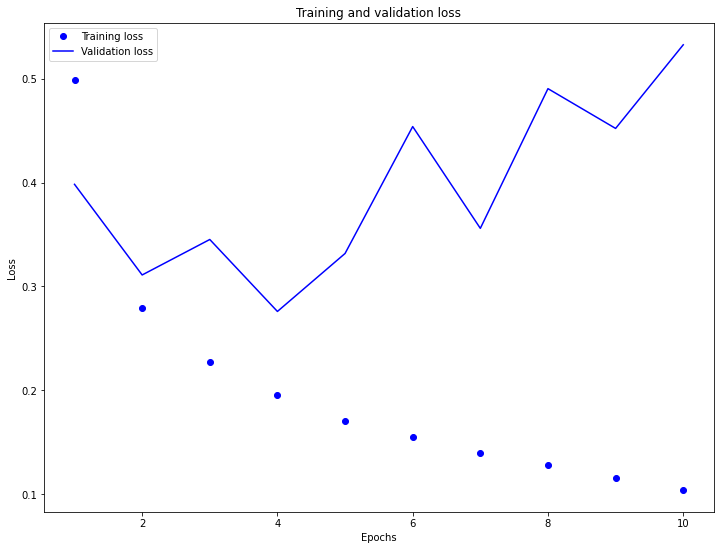

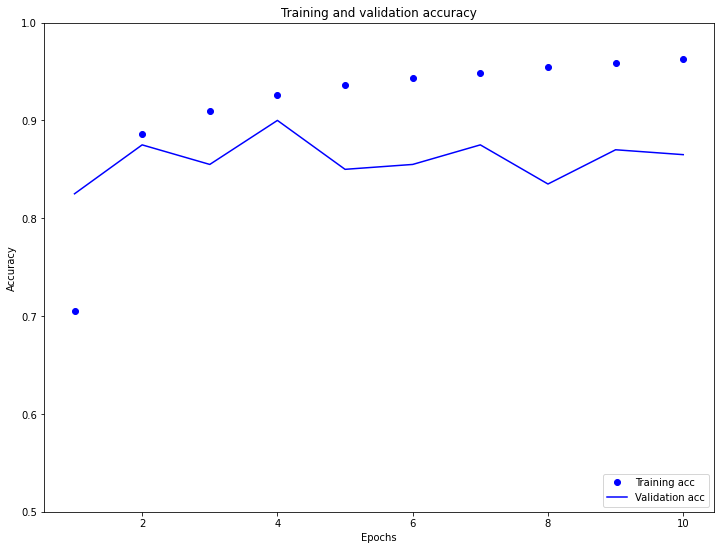

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim((0.5, 1))
plt.show()

## Recuperación de los embeddings

In [17]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape  # shape: (vocab_size, embedding_dim)

(8185, 16)

In [18]:
import io

encoder = info.features["text"].encoder

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]  # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [19]:
!head meta.tsv

the_
, 
. 
a_
and_
of_
to_
s_
is_
br


In [20]:
!head vecs.tsv

0.11070959	0.084626414	-0.008618013	0.011528218	-0.074729554	0.1032185	0.035761356	0.09538691	0.07524498	-0.032778863	-0.005185133	-0.037440386	-0.08481105	0.11691715	-0.04265682	-0.094709165
0.07382455	0.10638756	0.0056597036	0.030290121	-0.038026758	0.05491492	0.002350866	0.0057207695	0.009293043	0.11797054	0.03676013	0.03759388	-0.047128454	0.072976775	0.057435334	-0.13056973
-0.033548146	-0.061071105	0.050855402	-0.093871385	0.039426982	-0.03654196	-0.083198965	-0.033222053	-0.0107227685	-0.26459444	0.09045102	0.07336389	-0.03404533	-0.012912026	-0.005331952	-0.16289125
0.024449961	0.07459897	0.03040945	0.035011314	-0.076002434	0.014158559	-0.030919837	-0.024761138	-0.025279384	-0.07976803	-0.005039749	0.046094842	-0.09101193	0.0273557	-0.022751825	-0.1300635
0.15596202	0.110141374	-0.0919083	0.024115697	-0.19444986	0.09538838	0.03972578	0.086846404	0.11104989	0.053121917	-0.06653189	-0.0021813794	-0.14297186	0.13098595	-0.09569941	-0.230508
-0.07456555	-0.016944513	0.08087835	-0.1